In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf  

In [9]:
#Load data
train_df = pd.read_csv(r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\train_filtered_200.csv")
test_df = pd.read_csv(r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Github Repository\Airbnb-spatiotemporal\test_filtered_200.csv")

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime

def analyze_listing_prices(train_df, test_df, listing_id):
    """Analyze price patterns for a single listing"""
    # Get listing data
    listing_train = train_df[train_df['listing_id'] == listing_id].copy()
    listing_test = test_df[test_df['listing_id'] == listing_id].copy()
    
    # Sort by date
    listing_train['date'] = pd.to_datetime(listing_train['date'])
    listing_train = listing_train.sort_values('date')
    
    # Calculate price changes
    listing_train['price_change'] = listing_train['price'].diff()
    
    analysis = {
        'n_observations': len(listing_train),
        'date_range': (listing_train['date'].min(), listing_train['date'].max()),
        'unique_prices': sorted(listing_train['price'].unique()),
        'n_price_changes': (listing_train['price_change'] != 0).sum(),
        'price_stats': listing_train['price'].describe(),
        'test_period_length': len(listing_test)
    }
    
    return analysis

# Usage:
listing_id = train_df['listing_id'].iloc[0]
analysis = analyze_listing_prices(train_df, test_df, listing_id)
print("Analysis Results:")
print(f"Number of observations: {analysis['n_observations']}")
print(f"Date range: {analysis['date_range'][0]} to {analysis['date_range'][1]}")
print(f"Number of unique prices: {len(analysis['unique_prices'])}")
print(f"Unique prices: {analysis['unique_prices']}")
print(f"Number of price changes: {analysis['n_price_changes']}")
print("\nPrice statistics:")
print(analysis['price_stats'])

Analysis Results:
Number of observations: 365
Date range: 2024-04-01 00:00:00 to 2025-03-31 00:00:00
Number of unique prices: 2
Unique prices: [np.float64(-0.2671419902562501), np.float64(0.6768334447703809)]
Number of price changes: 2

Price statistics:
count    365.000000
mean       0.154414
std        0.469930
min       -0.267142
25%       -0.267142
50%       -0.267142
75%        0.676833
max        0.676833
Name: price, dtype: float64


In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def analyze_stationarity_and_patterns(train_df, listing_id):
    # Prepare data for one listing
    listing_data = train_df[train_df['listing_id'] == listing_id].copy()
    listing_data['date'] = pd.to_datetime(listing_data['date'])
    listing_data = listing_data.sort_values('date')
    
    # 1. Stationarity Test
    adf_result = adfuller(listing_data['price'])
    
    # 2. Price Change Analysis
    listing_data['price_change'] = listing_data['price'].diff()
    listing_data['day_of_week'] = listing_data['date'].dt.dayofweek
    listing_data['month'] = listing_data['date'].dt.month
    
    # Find when changes occur
    changes = listing_data[listing_data['price_change'] != 0]
    
    # 3. Pattern Analysis
    patterns = {
        'stationarity': {
            'adf_statistic': adf_result[0],
            'p_value': adf_result[1],
            'is_stationary': adf_result[1] < 0.05
        },
        'changes': {
            'total_changes': len(changes),
            'change_dates': changes['date'].tolist(),
            'change_days': changes['day_of_week'].tolist(),
            'change_months': changes['month'].tolist()
        }
    }
    
    return patterns

# Run the analysis
patterns = analyze_stationarity_and_patterns(train_df, listing_id)

In [12]:
patterns

{'stationarity': {'adf_statistic': np.float64(-1.1108210854694311),
  'p_value': np.float64(0.7107373455282875),
  'is_stationary': np.False_},
 'changes': {'total_changes': 2,
  'change_dates': [Timestamp('2024-04-01 00:00:00'),
   Timestamp('2024-09-11 00:00:00')],
  'change_days': [0, 2],
  'change_months': [4, 9]}}

#### Not stationary --> Go in differences??
We use ARIMA(2,1,2)
But ARIMA(1,0,1) works better and shows no overfitting

In [15]:
def fit_arima(train_df, test_df, listing_id):
    """
    ARIMA(1,0,1) implementation with improved convergence handling
    """
    # Prepare data
    train_data = train_df[train_df['listing_id'] == listing_id].copy()
    test_data = test_df[test_df['listing_id'] == listing_id].copy()
    
    # Convert to datetime and sort, explicitly set frequency to Daily
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    train_data = train_data.sort_values('date').set_index('date')
    test_data = test_data.sort_values('date').set_index('date')
    
    # Explicitly set the frequency to Daily
    train_data = train_data.asfreq('D')
    test_data = test_data.asfreq('D')
    
    # Fit ARIMA(1,0,1) with multiple optimization attempts
    model = SARIMAX(train_data['price'], 
                    order=(1,0,1),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    # Try different optimization methods
    methods = ['nm', 'bfgs', 'lbfgs', 'powell']
    max_iter = 500  # Increase maximum iterations
    
    for method in methods:
        try:
            results = model.fit(disp=False,
                              method=method,
                              maxiter=max_iter,
                              optim_score='harvey',  # More robust scoring
                              warn_convergence=False)  # Suppress warnings
            
            # If we got here without error, break the loop
            break
        except:
            continue
    else:
        # If all methods fail, try one last time with increased iterations
        results = model.fit(disp=False,
                          method='nm',
                          maxiter=1000,
                          optim_score='harvey',
                          warn_convergence=False)
    
    # Make predictions
    predictions = results.forecast(steps=len(test_data))
    
    # Calculate metrics
    errors = test_data['price'] - predictions
    rmse = np.sqrt(mean_squared_error(test_data['price'], predictions))
    mae = mean_absolute_error(test_data['price'], predictions)
    
    # Calculate autocorrelation metric
    error_acf = acf(errors, nlags=7)
    mean_acf = np.mean(np.abs(error_acf[1:]))
    
    # Calculate error stability metrics
    error_volatility = pd.Series(errors).rolling(window=7).std().mean()
    n_runs, runs_ratio = runs_test(errors)
    
    # Create stability score
    norm_volatility = error_volatility / (np.std(errors) + 1e-6)
    stability_score = (1 - norm_volatility + runs_ratio) / 2
    
    return predictions, rmse, mae, mean_acf, stability_score, results

# Get a listing ID
listing_id = train_df['listing_id'].iloc[0]

# Fit ARIMA and get results
predictions, rmse, mae, mean_acf, stability_score, results = fit_arima(train_df, test_df, listing_id)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'Mean ACF: {mean_acf:.4f}')
print(f'Stability Score: {stability_score:.4f}')


RMSE: 0.0591
MAE: 0.0523
Mean ACF: 0.8030
Stability Score: 0.4705


In [16]:
def fit_arima_all_listings(train_df, test_df):
    """
    Fits ARIMA(1,0,1) for all listings with improved error handling
    """
    listings = list(set(train_df['listing_id']).intersection(set(test_df['listing_id'])))
    results_dict = {}
    failed_listings = []
    
    for listing_id in listings:
        try:
            predictions, rmse, mae, mean_acf, stability_score, model = fit_arima(train_df, test_df, listing_id)
            results_dict[listing_id] = {
                'predictions': predictions,
                'rmse': rmse,
                'mae': mae,
                'mean_acf': mean_acf,
                'stability_score': stability_score,
                'model': model
            }
            print(f"\nMetrics for listing {listing_id}:")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"Mean ACF: {mean_acf:.4f}")
            print(f"Stability Score: {stability_score:.4f}")
            
        except Exception as e:
            print(f"Failed to process listing {listing_id}: {str(e)}")
            failed_listings.append(listing_id)
            continue
    
    if failed_listings:
        print("\nFailed listings:", failed_listings)
    
    # Print summary only for successful fits
    if results_dict:
        all_rmse = [res['rmse'] for res in results_dict.values()]
        all_mae = [res['mae'] for res in results_dict.values()]
        all_acf = [res['mean_acf'] for res in results_dict.values()]
        all_stability = [res['stability_score'] for res in results_dict.values()]
        
        print("\nAverage metrics across successful listings:")
        print(f"Average RMSE: {np.mean(all_rmse):.4f}")
        print(f"Average MAE: {np.mean(all_mae):.4f}")
        print(f"Average Mean ACF: {np.mean(all_acf):.4f}")
        print(f"Average Stability Score: {np.mean(all_stability):.4f}")
        print(f"Successfully processed {len(results_dict)}/{len(listings)} listings")
    
    return results_dict

# Use it like this:
results = fit_arima_all_listings(train_df, test_df)


Metrics for listing 11265:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5278

Metrics for listing 91139:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5315

Metrics for listing 227846:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5265

Metrics for listing 42507:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5209

Metrics for listing 21004:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.4976

Metrics for listing 39948:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.4962

Metrics for listing 142859:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5055

Metrics for listing 178188:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5272

Metrics for listing 231442:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5303

Metrics for listing 43027:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5204

Metrics for listing 61459:
RMSE: 0.0000
MAE: 0.0000
Mea

In [17]:
def analyze_arima_results(train_df, test_df, results_dict):
    """
    Comprehensive analysis of ARIMA model results
    """
    analysis_results = {}
    
    for listing_id, results in results_dict.items():
        model = results['model']
        predictions = results['predictions']
        
        # Get actual test data for this listing
        test_data = test_df[test_df['listing_id'] == listing_id].copy()
        test_data['date'] = pd.to_datetime(test_data['date'])
        test_data = test_data.sort_values('date').set_index('date')
        
        # 1. Model Parameters
        params = model.params
        
        # 2. Model Fit Statistics
        fit_stats = {
            'aic': model.aic,
            'bic': model.bic,
            'rmse': results['rmse'],
            'mae': results['mae'],
            'mean_acf': results['mean_acf'],
            'stability_score': results['stability_score']
        }
        
        # 3. Error Analysis
        errors = test_data['price'] - predictions
        error_stats = {
            'mean_error': errors.mean(),
            'error_std': errors.std(),
            'max_error': errors.max(),
            'min_error': errors.min()
        }
        
        # 4. Price Change Analysis
        test_data['price_change'] = test_data['price'].diff()
        n_changes = (test_data['price_change'] != 0).sum()
        
        # Store all results
        analysis_results[listing_id] = {
            'parameters': params,
            'fit_statistics': fit_stats,
            'error_statistics': error_stats,
            'price_changes': n_changes
        }
    
    return analysis_results

def print_analysis_summary(analysis_results):
    """
    Print summary of the analysis results
    """
    # Calculate average metrics across all listings
    all_rmse = [res['fit_statistics']['rmse'] for res in analysis_results.values()]
    all_mae = [res['fit_statistics']['mae'] for res in analysis_results.values()]
    all_acf = [res['fit_statistics']['mean_acf'] for res in analysis_results.values()]
    all_stability = [res['fit_statistics']['stability_score'] for res in analysis_results.values()]
    
    print("\nOverall Model Performance:")
    print(f"Average RMSE: {np.mean(all_rmse):.4f}")
    print(f"Average MAE: {np.mean(all_mae):.4f}")
    print(f"Average Mean ACF: {np.mean(all_acf):.4f}")
    print(f"Average Stability Score: {np.mean(all_stability):.4f}")
    
    # Print detailed results for a sample listing
    sample_listing = list(analysis_results.keys())[0]
    res = analysis_results[sample_listing]
    
    print(f"\nDetailed Analysis for Listing {sample_listing}:")
    print("\nModel Parameters:")
    print(res['parameters'])
    
    print("\nFit Statistics:")
    for stat, value in res['fit_statistics'].items():
        print(f"{stat}: {value:.4f}")
    
    print("\nError Statistics:")
    for stat, value in res['error_statistics'].items():
        print(f"{stat}: {value:.4f}")
    
    print(f"\nNumber of price changes: {res['price_changes']}")

def plot_sample_predictions(train_df, test_df, results_dict, listing_id):
    """
    Plot actual vs predicted prices for a sample listing
    """
    predictions = results_dict[listing_id]['predictions']
    
    test_data = test_df[test_df['listing_id'] == listing_id].copy()
    test_data['date'] = pd.to_datetime(test_data['date'])
    test_data = test_data.sort_values('date').set_index('date')
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data['price'], label='Actual', color='blue')
    plt.plot(test_data.index, predictions, label='Predicted', color='red', linestyle='--')
    plt.title(f'ARIMA Predictions vs Actual Prices - Listing {listing_id}')
    plt.xlabel('Date')
    plt.ylabel('Standardized Price')
    plt.legend()
    plt.grid(True)
    return plt



Metrics for listing 3109:
RMSE: 0.0591
MAE: 0.0523
Mean ACF: 0.8030
Stability Score: 0.4705

Metrics for listing 5396:
RMSE: 0.0055
MAE: 0.0049
Mean ACF: 0.8002
Stability Score: 0.4706

Metrics for listing 7397:
RMSE: 0.0126
MAE: 0.0112
Mean ACF: 0.8023
Stability Score: 0.4705

Metrics for listing 7964:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5204

Metrics for listing 9359:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5304

Metrics for listing 9952:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5308

Metrics for listing 10586:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5308

Metrics for listing 10588:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5304

Metrics for listing 11265:
RMSE: 0.0000
MAE: 0.0000
Mean ACF: 0.8042
Stability Score: 0.5278

Metrics for listing 11487:
RMSE: 0.0116
MAE: 0.0101
Mean ACF: 0.8042
Stability Score: 0.4704

Metrics for listing 11798:
RMSE: 0.0059
MAE: 0.0052
Mean ACF: 0.8

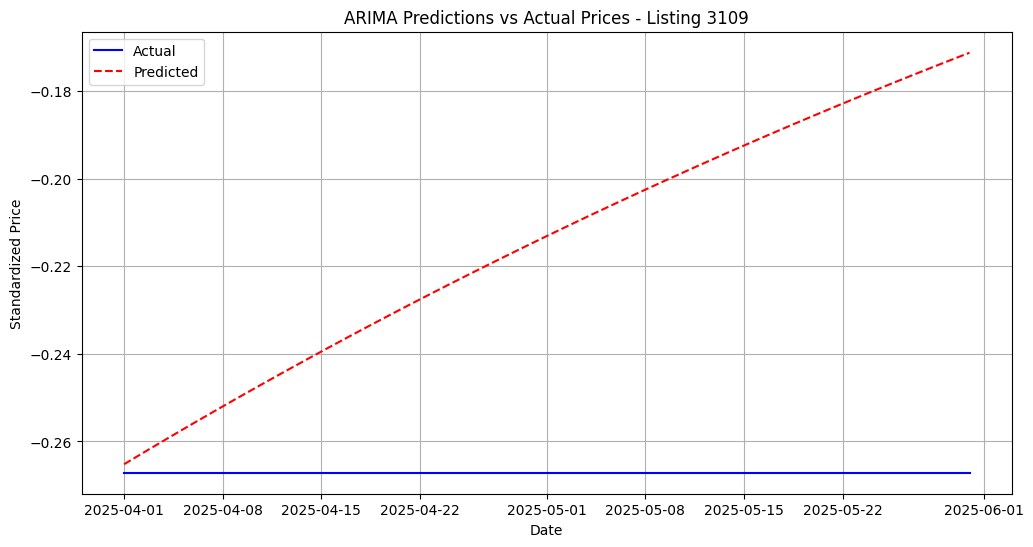

In [18]:
# Main execution code
results_dict = {}
for listing_id in train_df['listing_id'].unique():
    try:
        predictions, rmse, mae, mean_acf, stability_score, model = fit_arima(train_df, test_df, listing_id)
        results_dict[listing_id] = {
            'predictions': predictions,
            'rmse': rmse,
            'mae': mae,
            'mean_acf': mean_acf,
            'stability_score': stability_score,
            'model': model
        }
        print(f"\nMetrics for listing {listing_id}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Mean ACF: {mean_acf:.4f}")
        print(f"Stability Score: {stability_score:.4f}")
    except Exception as e:
        print(f"Error processing listing {listing_id}: {str(e)}")
        continue

# Analyze results
analysis_results = analyze_arima_results(train_df, test_df, results_dict)
print_analysis_summary(analysis_results)

# Plot sample predictions
sample_listing = list(results_dict.keys())[0]
plot = plot_sample_predictions(train_df, test_df, results_dict, sample_listing)
plt.show()

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

def runs_test(sequence):
    """
    Implement a simple runs test to check for randomness
    Returns the number of runs and the ratio of runs to length
    """
    # Convert to binary sequence based on being above/below mean
    mean = np.mean(sequence)
    binary = (sequence > mean).astype(int)
    
    # Count runs
    runs = 1
    for i in range(1, len(binary)):
        if binary.iloc[i] != binary.iloc[i-1]:  # Changed to use iloc
            runs += 1
    
    # Calculate runs ratio (actual runs / expected runs for random sequence)
    n1 = sum(binary)
    n2 = len(binary) - n1
    expected_runs = ((2 * n1 * n2) / len(binary)) + 1
    runs_ratio = runs / expected_runs
    
    return runs, runs_ratio

def analyze_arima_results(train_df, test_df, results_dict):
    """
    Enhanced analysis of ARIMA model results including temporal patterns
    """
    analysis_results = {}
    
    for listing_id, results in results_dict.items():
        model = results['model']
        predictions = results['predictions']
        
        # Get test data
        test_data = test_df[test_df['listing_id'] == listing_id].copy()
        test_data['date'] = pd.to_datetime(test_data['date'])
        test_data = test_data.sort_values('date').set_index('date')
        
        # 1. Model Parameters
        params = model.params
        
        # 2. Basic Fit Statistics
        fit_stats = {
            'aic': model.aic,
            'bic': model.bic,
            'rmse': results['rmse'],
            'mae': results['mae']
        }
        
        # 3. Error Analysis
        errors = test_data['price'] - predictions
        error_stats = {
            'mean_error': errors.mean(),
            'error_std': errors.std(),
            'max_error': errors.max(),
            'min_error': errors.min()
        }
        
        # 4. Temporal Pattern Analysis
        
        # 4.1 Autocorrelation of errors (lag 1 to 7 days)
        error_acf = acf(errors, nlags=7)
        
        # 4.2 Error stability over time
        n_runs, runs_ratio = runs_test(errors)
        error_stability = {
            'error_trend': np.polyfit(range(len(errors)), errors, 1)[0],  # Linear trend in errors
            'error_volatility': pd.Series(errors).rolling(window=7).std().mean(),  # Rolling volatility
            'runs_count': n_runs,
            'runs_ratio': runs_ratio  # Ratio close to 1 suggests randomness
        }
        
        # 4.3 Day-of-week effect
        test_data['day_of_week'] = test_data.index.dayofweek
        dow_effects = test_data.groupby('day_of_week')['price'].mean()
        
        # 4.4 Price change patterns
        price_changes = test_data['price'].diff()
        price_pattern_stats = {
            'n_changes': (price_changes != 0).sum(),
            'mean_change': price_changes[price_changes != 0].mean(),
            'change_volatility': price_changes[price_changes != 0].std(),
            'positive_changes_ratio': (price_changes > 0).sum() / (price_changes != 0).sum() if (price_changes != 0).sum() > 0 else 0
        }
        
        # 4.5 Prediction error by day of week
        error_by_dow = pd.Series(errors).groupby(test_data.index.dayofweek).mean()
        
        # Store all results
        analysis_results[listing_id] = {
            'parameters': params,
            'fit_statistics': fit_stats,
            'error_statistics': error_stats,
            'temporal_patterns': {
                'error_autocorrelation': error_acf,
                'error_stability': error_stability,
                'day_of_week_effects': dow_effects,
                'price_patterns': price_pattern_stats,
                'error_by_dow': error_by_dow
            }
        }
    
    return analysis_results

def print_enhanced_analysis_summary(analysis_results):
    """
    Print detailed summary including temporal pattern analysis
    """
    # Calculate average metrics across all listings
    all_rmse = [res['fit_statistics']['rmse'] for res in analysis_results.values()]
    all_mae = [res['fit_statistics']['mae'] for res in analysis_results.values()]
    
    print("\nOverall Model Performance:")
    print(f"Average RMSE: {np.mean(all_rmse):.4f}")
    print(f"Average MAE: {np.mean(all_mae):.4f}")
    
    # Print detailed results for a sample listing
    sample_listing = list(analysis_results.keys())[0]
    res = analysis_results[sample_listing]
    
    print(f"\nDetailed Analysis for Listing {sample_listing}:")
    
    print("\nModel Parameters:")
    print(res['parameters'])
    
    print("\nFit Statistics:")
    for stat, value in res['fit_statistics'].items():
        print(f"{stat}: {value:.4f}")
    
    print("\nError Statistics:")
    for stat, value in res['error_statistics'].items():
        print(f"{stat}: {value:.4f}")
    
    print("\nTemporal Pattern Analysis:")
    print("\nError Autocorrelation (lags 1-7):")
    for lag, acf_value in enumerate(res['temporal_patterns']['error_autocorrelation']):
        print(f"Lag {lag}: {acf_value:.4f}")
    
    print("\nError Stability:")
    for metric, value in res['temporal_patterns']['error_stability'].items():
        print(f"{metric}: {value:.4f}")
        
    print("\nDay of Week Effects:")
    for day, effect in res['temporal_patterns']['day_of_week_effects'].items():
        print(f"Day {day}: {effect:.4f}")
    
    print("\nPrice Change Patterns:")
    for metric, value in res['temporal_patterns']['price_patterns'].items():
        if isinstance(value, float):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")

def plot_enhanced_analysis(train_df, test_df, results_dict, listing_id):
    """
    Create multiple plots for detailed analysis
    """
    predictions = results_dict[listing_id]['predictions']
    test_data = test_df[test_df['listing_id'] == listing_id].copy()
    test_data['date'] = pd.to_datetime(test_data['date'])
    test_data = test_data.sort_values('date').set_index('date')
    errors = test_data['price'] - predictions
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))
    
    # Plot 1: Actual vs Predicted
    axes[0].plot(test_data.index, test_data['price'], label='Actual', color='blue')
    axes[0].plot(test_data.index, predictions, label='Predicted', color='red', linestyle='--')
    axes[0].set_title('Actual vs Predicted Prices')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Standardized Price')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot 2: Error Distribution
    axes[1].hist(errors, bins=30, color='skyblue', alpha=0.7)
    axes[1].axvline(errors.mean(), color='red', linestyle='--', label='Mean Error')
    axes[1].set_title('Error Distribution')
    axes[1].set_xlabel('Error')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    # Plot 3: Error Autocorrelation
    lags = range(1, 8)
    error_acf = acf(errors, nlags=7)
    axes[2].bar(lags, error_acf[1:], color='skyblue', alpha=0.7)
    axes[2].set_title('Error Autocorrelation')
    axes[2].set_xlabel('Lag (days)')
    axes[2].set_ylabel('Autocorrelation')
    axes[2].grid(True)
    
    plt.tight_layout()
    return plt


Overall Model Performance:
Average RMSE: 0.0029
Average MAE: 0.0026

Detailed Analysis for Listing 3109:

Model Parameters:
ar.L1     0.992733
ma.L1     0.002118
sigma2    0.002440
dtype: float64

Fit Statistics:
aic: -1147.2605
bic: -1135.5773
rmse: 0.0591
mae: 0.0523

Error Statistics:
mean_error: -0.0523
error_std: 0.0278
max_error: -0.0019
min_error: -0.0959

Temporal Pattern Analysis:

Error Autocorrelation (lags 1-7):
Lag 0: 1.0000
Lag 1: 0.9504
Lag 2: 0.9009
Lag 3: 0.8516
Lag 4: 0.8025
Lag 5: 0.7536
Lag 6: 0.7050
Lag 7: 0.6568

Error Stability:
error_trend: -0.0016
error_volatility: 0.0034
runs_count: 2.0000
runs_ratio: 0.0636

Day of Week Effects:
Day 0: -0.2671
Day 1: -0.2671
Day 2: -0.2671
Day 3: -0.2671
Day 4: -0.2671
Day 5: -0.2671
Day 6: -0.2671

Price Change Patterns:
n_changes: 1
mean_change: nan
change_volatility: nan
positive_changes_ratio: 0.0000


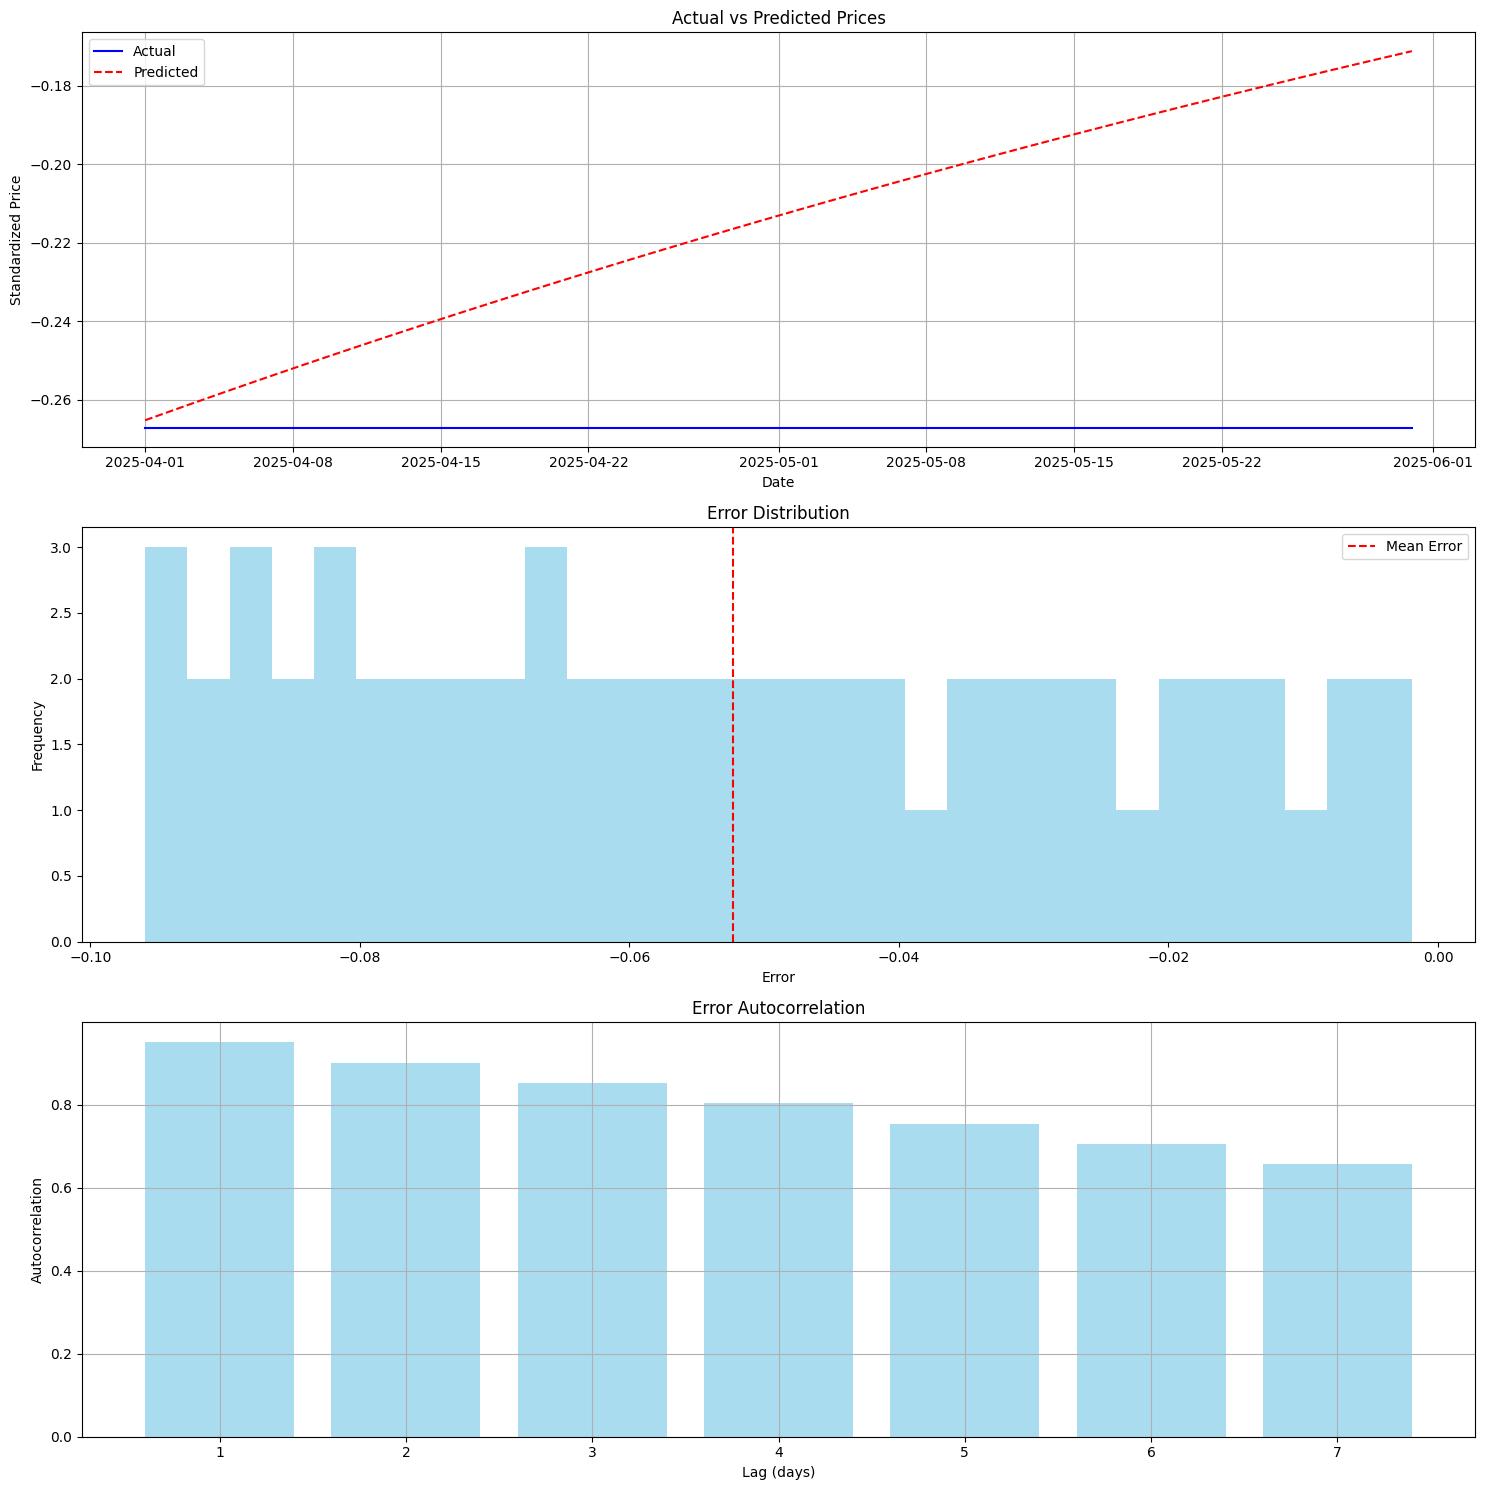

In [20]:
# Run the enhanced analysis
analysis_results = analyze_arima_results(train_df, test_df, results_dict)

# Print summary
print_enhanced_analysis_summary(analysis_results)

# Plot analysis for first listing
listing_id = train_df['listing_id'].iloc[1]
plot = plot_enhanced_analysis(train_df, test_df, results_dict, listing_id)
plt.show()